In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
model = tf.keras.applications.MobileNetV2(include_top= True,weights='imagenet')
model.trainable = False
decode_pred = tf.keras.applications.mobilenet_v2.decode_predictions

In [ ]:
def preprocess(image):
  image = tf.cast(image,tf.float32)
  image = tf.image.resize(image,(224,224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None,:]
  return image

def get_imagenet_label(probs):
  return decode_pred(probs,top=1)[0][0]

## Original Image

In [ ]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = model.predict(image)

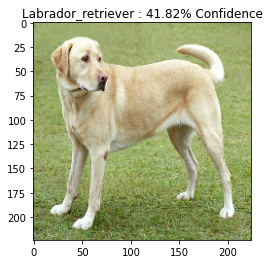

In [ ]:
plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

### Creating the adversarial image

In [ ]:
loss_obj = tf.keras.losses.CategoricalCrossentropy()

def create_adv_pattern(input_image,input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    pred = model(input_image)
    loss = loss_obj(input_label,pred)
  grad = tape.gradient(loss,input_image)
  signed_grad = tf.sign(grad)
  return signed_grad

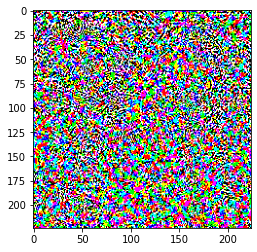

In [ ]:
lab_ret_idx = 208
label = tf.one_hot(lab_ret_idx,image_probs.shape[-1])
label = tf.reshape(label,(1,image_probs.shape[-1]))

perturbations = create_adv_pattern(image,label)
plt.imshow(perturbations[0]*0.5+0.5)

In [ ]:
def display_images(image,description):
  _,label,confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title(description+"  "+label+": "+str(confidence))
  plt.show()

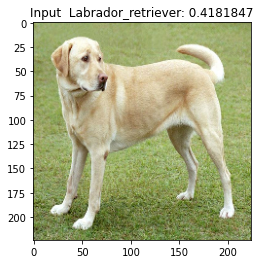

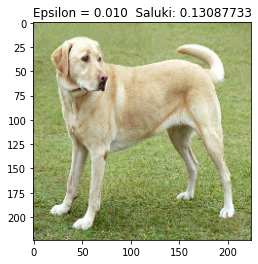

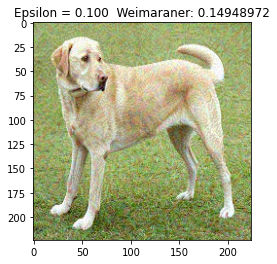

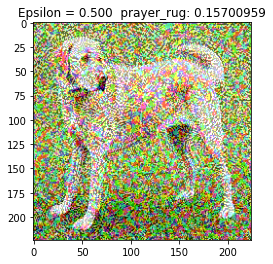

In [ ]:
epsilon = [0,0.01,0.1,0.5]
description = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilon]

for i, eps in enumerate(epsilon):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x,-1,1)
  display_images(adv_x,description[i])